In [47]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-05-07 14:42:30.779295: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 14:42:30.813442: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 14:42:30.813483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 14:42:30.814315: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-07 14:42:30.820346: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-07 14:42:30.821580: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [ ]:
from load_data import load_data_from_ultralytics_dataset

image_label_mapping = load_data_from_ultralytics_dataset()

# You can now access the images and their corresponding labels
for image_path, data in image_label_mapping.items():
    image = data["image"]
    label = data["label"]
    print(f"Image: {image_path}, Label: {label}")

In [21]:
print(len(image_label_mapping))
first_key = list(image_label_mapping)[0]
first_data = image_label_mapping[first_key]
print(first_key)
# image_label_mapping[first_key]

100
datasets/ball_only_dataset_80-60/images/zjywakpbceocyoqcnexhdx/0096053.png


0 0.5062394142150879 0.651924893257884 0.26647882461547845 0.35421494841151985

40.49915313720703


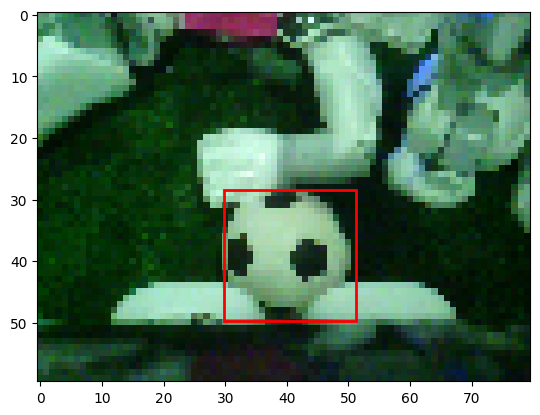

In [31]:
# Load the image
image = Image.open(list(image_label_mapping)[0])
img_width, img_height = image.size

# Create a figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)
print(first_data["label"])
cls_id, cx, cy, w, h = first_data["label"].split(" ")
# that does not deal with multiple lines well yet, maybe do it like this:
"""
for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
"""

cx = float(cx) * img_width
cy = float(cy) * img_height
w = float(w) * img_width
h = float(h) * img_height
print(cx)
bounding_box = patches.Rectangle((cx - (w / 2), cy - (h / 2)), w, h, fill=False, edgecolor="red", linewidth=2)
ax.add_patch(bounding_box)

## Convert annotation to grid annotation

In [37]:
def bounding_boxes_to_grid(batch_bboxes, grid_size=7, image_shape=(60, 80)):
    """
    Args:
    - batch_bboxes: A list of lists containing bounding boxes for each image in the batch.
      Each bounding box is represented as [class_id, center_x, center_y, width, height], where
      center_x and center_y are in absolute image coordinates.
    - grid_size: Number of grid cells along each axis.
    - image_shape: Shape of the input images [height, width].

    Returns:
    - ground_truth: Ground truth tensor with shape [batch_size, grid_size, grid_size, 5].
    """

    grid_height, grid_width = grid_size, grid_size
    image_height, image_width = image_shape

    # Initialize the ground truth tensor
    ground_truth = np.zeros((grid_height, grid_width, 5))

    for bbox in batch_bboxes:

        conf, center_x, center_y, box_width, box_height, class_id = bbox

        # Determine grid cell indices for the bounding box center
        grid_x = int((center_x / image_width) * grid_width)
        grid_y = int((center_y / image_height) * grid_height)

        # Calculate relative positions and sizes within the grid
        rel_center_x = (center_x % (image_width / grid_width)) / (image_width / grid_width)
        rel_center_y = (center_y % (image_height / grid_height)) / (image_height / grid_height)
        rel_width = box_width / image_width * grid_width
        rel_height = box_height / image_height * grid_height

        # Assign the ground truth values
        ground_truth[grid_y, grid_x, :] = [class_id, rel_center_x, rel_center_y, rel_width, rel_height]

    return ground_truth

In [40]:
batch_bounding_boxes = [[1, 39, 30, 13, 13, 1], [1, 4, 4, 13, 13, 1]]

# FIXME this has an important problem it produced
output = bounding_boxes_to_grid(batch_bounding_boxes)
print(output.shape)

(7, 7, 5)


In [52]:
# Prepare dataset for training

label_list = list()
image_list = list()

for image_path, data in image_label_mapping.items():
    image = data["image"]
    label = data["label"]
    cls_id, cx, cy, w, h = label.split(" ")  # FIXME work with multiple labels per image
    # bounding_boxes_to_grid expects absolute coordinates
    cx = float(cx) * img_width
    cy = float(cy) * img_height
    w = float(w) * img_width
    h = float(h) * img_height
    bounding_boxes = [[cls_id, cx, cy, w, h, 1]]
    converted_labels = bounding_boxes_to_grid(bounding_boxes)
    print(type(converted_labels))
    label_list.append(converted_labels)
    image_list.append(data["image"])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

loss function is taken from https://github.com/srihari-humbarwadi/YOLOv1-TensorFlow2.0/blob/c438e49926f0d7fa0b949698f27f7f2e583ca9b7/yolo_v1.py

In [60]:
grid_size = (7, 7)
nboxes = 1
H, W = 60, 80


def compute_iou(boxes1, boxes2):
    boxes1_t = tf.stack(
        [
            boxes1[..., 0] - boxes1[..., 2] / 2.0,
            boxes1[..., 1] - boxes1[..., 3] / 2.0,
            boxes1[..., 0] + boxes1[..., 2] / 2.0,
            boxes1[..., 1] + boxes1[..., 3] / 2.0,
        ],
        axis=-1,
    )

    boxes2_t = tf.stack(
        [
            boxes2[..., 0] - boxes2[..., 2] / 2.0,
            boxes2[..., 1] - boxes2[..., 3] / 2.0,
            boxes2[..., 0] + boxes2[..., 2] / 2.0,
            boxes2[..., 1] + boxes2[..., 3] / 2.0,
        ],
        axis=-1,
    )

    # calculate the left up point & right down point
    lu = tf.maximum(boxes1_t[..., :2], boxes2_t[..., :2])
    rd = tf.minimum(boxes1_t[..., 2:], boxes2_t[..., 2:])

    # intersection
    intersection = tf.maximum(0.0, rd - lu)
    inter_square = intersection[..., 0] * intersection[..., 1]

    # calculate the boxs1 square and boxs2 square
    square1 = boxes1[..., 2] * boxes1[..., 3]
    square2 = boxes2[..., 2] * boxes2[..., 3]

    union_square = tf.maximum(square1 + square2 - inter_square, 1e-10)

    return tf.clip_by_value(inter_square / union_square, 0.0, 1.0)


offset = []
offset_tran = []
for i in range(grid_size[0]):
    row = []
    row_trans = []
    for j in range(grid_size[0]):
        row.append(j)
        row_trans.append(i)
    offset.append(row)
    offset_tran.append(row_trans)
offset = np.tile(np.array(offset)[None, :, :, None], reps=[1, 1, 1, nboxes])
offset_tran = np.tile(np.array(offset_tran)[None, :, :, None], reps=[1, 1, 1, nboxes])

offset = tf.constant(offset, dtype=tf.float32)
offset_tran = tf.constant(offset_tran, dtype=tf.float32)


def yolo_loss2(y_true=None, y_pred=None, eval=False):
    nboxes = 1
    grid_size = (7, 7)
    pred_obj_conf = y_pred[:, :, :, :nboxes]
    pred_box_classes = y_pred[:, :, :, 5 * nboxes :]
    pred_box_offset_coord = y_pred[:, :, :, nboxes : 5 * nboxes]
    pred_box_offset_coord = tf.reshape(pred_box_offset_coord, shape=[-1, grid_size[0], grid_size[0], nboxes, 4])
    pred_box_normalized_coord = tf.stack(
        [
            (pred_box_offset_coord[:, :, :, :, 0] + offset) / grid_size[0],
            (pred_box_offset_coord[:, :, :, :, 1] + offset_tran) / grid_size[0],
            tf.square(pred_box_offset_coord[:, :, :, :, 2]),
            tf.square(pred_box_offset_coord[:, :, :, :, 3]),
        ],
        axis=-1,
    )
    if eval:
        return pred_obj_conf, pred_box_classes, pred_box_normalized_coord
    target_obj_conf = y_true[:, :, :, :1]
    target_box_classes = y_true[:, :, :, 5:]
    target_box_coord = y_true[:, :, :, 1:5]
    target_box_coord = tf.reshape(target_box_coord, shape=[-1, grid_size[0], grid_size[1], 1, 4])
    target_box_coord = tf.tile(target_box_coord, multiples=[1, 1, 1, nboxes, 1])
    target_box_normalized_coord = target_box_coord / H
    target_box_offset_coord = tf.stack(
        [
            target_box_normalized_coord[:, :, :, :, 0] * grid_size[0] - offset,
            target_box_normalized_coord[:, :, :, :, 1] * grid_size[0] - offset_tran,
            tf.sqrt(target_box_normalized_coord[:, :, :, :, 2]),
            tf.sqrt(target_box_normalized_coord[:, :, :, :, 3]),
        ],
        axis=-1,
    )

    pred_ious = compute_iou(target_box_normalized_coord, pred_box_normalized_coord)
    predictor_mask = tf.reduce_max(pred_ious, axis=3, keepdims=True)
    predictor_mask = tf.cast(pred_ious >= predictor_mask, tf.float32) * target_obj_conf
    noobj_mask = tf.ones_like(predictor_mask) - predictor_mask

    # Computing the class loss
    class_loss = tf.reduce_mean(
        tf.reduce_sum(tf.square(target_obj_conf * (target_box_classes - pred_box_classes)), axis=[1, 2, 3])
    )

    # computing the confidence loss
    obj_loss = tf.reduce_mean(tf.reduce_sum(tf.square(predictor_mask * (pred_obj_conf - pred_ious)), axis=[1, 2, 3]))
    noobj_loss = tf.reduce_mean(tf.reduce_sum(tf.square(noobj_mask * (pred_obj_conf)), axis=[1, 2, 3]))

    # computing the localization loss
    predictor_mask = predictor_mask[:, :, :, :, None]
    loc_loss = tf.reduce_mean(
        tf.reduce_sum(tf.square(predictor_mask * (target_box_offset_coord - pred_box_offset_coord)), axis=[1, 2, 3])
    )

    loss = 10 * loc_loss + obj_loss + 0.1 * noobj_loss + 0.5 * class_loss
    return loss


# Define the YOLO-like model
def create_yolo_model(input_shape=(60, 80, 3), grid_size=7):
    B = 1  # Number of bounding boxes per grid cell
    C = 1  # Number of classes
    model = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(60, 80, 3)),  # Image input
            tf.keras.layers.Conv2D(16, (3, 3), activation="relu", padding="same"),  # Basic convolution
            tf.keras.layers.MaxPooling2D((2, 2)),  # Simple pooling
            tf.keras.layers.Flatten(),  # Flatten the features
            tf.keras.layers.Dense(256, activation="relu"),  # Intermediate dense layer
            tf.keras.layers.Dense(grid_size * grid_size * (B * 5 + C)),  # Final dense layer for YOLO output
            tf.keras.layers.Reshape((grid_size, grid_size, B * 5 + C)),  # Reshape to the YOLO output shape
        ]
    )
    return model


model = create_yolo_model()
model.compile(optimizer="adam", loss=yolo_loss2, metrics=["accuracy"])

In [ ]:
print(type(image_list[0]))
print(type(label_list[0]))
image_list[0].shape
label_list[0].shape


print(len(image_list))
print(len(label_list))
x_train = np.array(image_list)
y_train = np.array(label_list)
model.fit(x_train, y_train, batch_size=32, epochs=100)

In [62]:
yolo_output = model.predict(np.expand_dims(image_list[0], axis=0))

1/1 [==============================] - 0s 73ms/step


0.8598618
0.1710753
-1.2991104
-0.07480081
0.20828007
0.36957002
-0.24095105
-0.6543536
1.0061474
-0.94805795
-0.44159728
0.92791903
0.3353868
-0.036505677
0.2834918
-1.6281797
-0.056980625
-0.42597318
-0.6218409
0.626829
0.3657939
-0.46217194
-0.6137713
0.6180465
0.37337577
0.31990054
0.21155582
-0.0022926386
-0.2621889
0.5038574
-0.21001965
0.49207935
-0.00408563
0.2460718
0.39501458
1.1281725
-0.12629333
0.22386909
-0.10523152
0.018249646
-0.26734197
-0.7619745
-0.5561915
-0.3672533
-0.2374666
-0.6755749
1.0111351
-1.8254607
-0.6037123
1.1281725


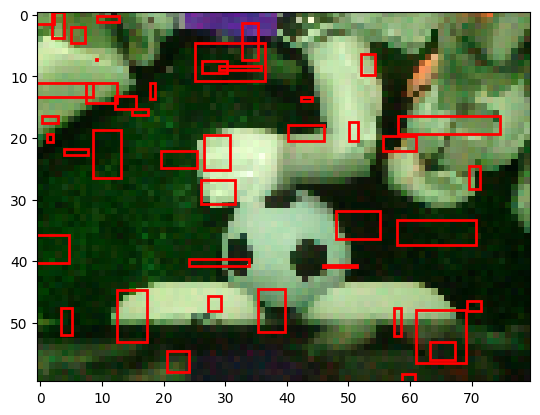

In [67]:
grid_size = yolo_output.shape[1]
image = image_list[0]
# print(grid_size)
height, width, _ = image.shape
fig, ax = plt.subplots()
# Display the image
ax.imshow(image)

score = 0.0

for i in range(grid_size):
    for j in range(grid_size):
        pred = yolo_output[0, i, j, :]
        class_id = pred[0]
        center_x = pred[1]
        center_y = pred[2]
        box_w = pred[3]
        box_h = pred[4]
        val = pred[5]
        print(val)
        if val > score:
            score = val
        # print(f"{i,j} cell: {pred}")
        # Convert from grid coordinates to absolute coordinates
        x = (j + center_x) / grid_size * width
        y = (i + center_y) / grid_size * height
        w = box_w * width / grid_size
        h = box_h * height / grid_size
        # print(x,y, w,h)
        # Convert to rectangle coordinates for plotting

        try:
            rect = plt.Rectangle((x - 0.5 * w, y - 0.5 * h), w, h, fill=False, color="red", linewidth=2)
            # print(rect)
            ax.add_patch(rect)
        except:
            pass
print(score)